In [104]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")
x_smooth, u_smooth, y_smooth , v_smooth = process_data.smooth_trajectories(x_raw,y_raw)

In [105]:
from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
target_points = [ (0,0) , (0,1), (1,1) ]
reference_points = [(0,0) , (0,height) , (width,height)]
x_smooth = np.array( map( lambda x: x/width , x_smooth ) )
u_smooth = np.array( map( lambda x: x/width , u_smooth ) )
y_smooth = np.array( map( lambda x: -x/height , y_smooth ) )
v_smooth = np.array( map( lambda x: -x/height , v_smooth ) )

In [106]:
from matplotlib import pyplot as plt
%matplotlib inline

(0.0, 1.0, 0.0, 1.0)

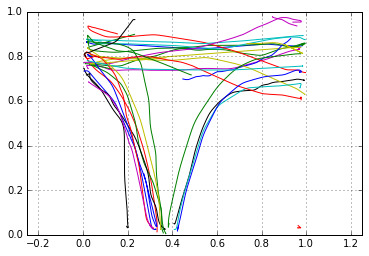

In [107]:
for k in range(len(x_smooth)):
    plt.plot(x_smooth[k],y_smooth[k])
plt.grid()
plt.axis('equal')

[0, 1, 0, 1]

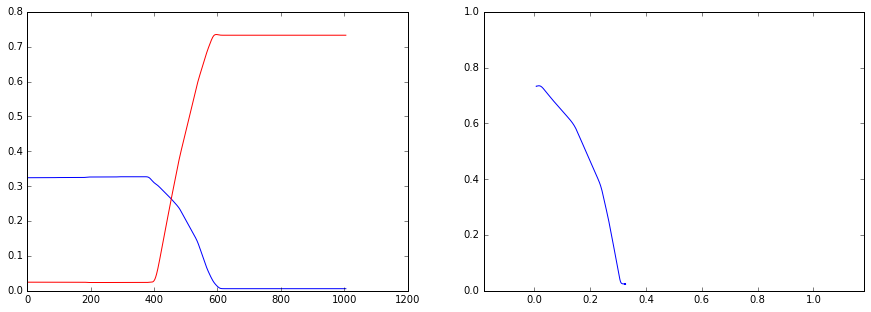

In [175]:
k = 14
fig, ax_arr = plt.subplots( 1,2 ,figsize=(15,5))
ax_arr[0].plot(x_smooth[k],'b-')
ax_arr[0].plot(y_smooth[k],'r-')
ax_arr[1].plot(x_smooth[k],y_smooth[k])
ax_arr[1].axis('equal')
ax_arr[1].axis([0,1,0,1])

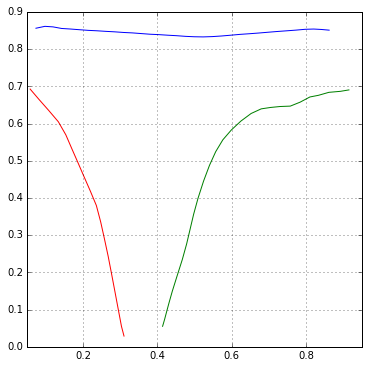

In [110]:
plt.figure(figsize=(6,6))
plt.plot(x_smooth[0][460:800:10],y_smooth[0][460:800:10])
plt.plot(x_smooth[6][270:550:10],y_smooth[6][270:550:10])
plt.plot(x_smooth[14][400:580:10],y_smooth[14][400:580:10])
plt.axis('equal')
plt.grid()

## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L_\theta( x,\dot{x}) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

We solve this boundary value problem with a shooting method, using the gradient of the initial condition to help us.  The variation of the initial condition $\delta \partial_\beta q^j_0$ is computed by solving
$$
    \frac{d^2 x^i}{dt^2} + \partial_i V(x) = 0 \\
    \frac{d^2 \partial_\alpha x^i }{dt^2} + \partial_\alpha \partial_i V(x) + \partial_{ik} V(x) \partial_\alpha x^k = 0 \\
    \frac{d^2}{dt^2} \left( \frac{ \delta \partial_\alpha x^i }{ \delta \partial_\beta x^j_0 } \right)
    + \partial_{ik}V(x) \frac{ \delta \partial_\alpha x^k }{\delta \partial_\beta x^j_0 }
$$
where $x^i(0)$ and $\partial_\alpha x^i (0)=0$ are given,
$x^i(1)$ and $\partial_\alpha x^i(1)$ are guessed,
and $\delta \partial_\alpha x^i(0)$ and $\delta \partial_\alpha x^i(1)$ are deduced from the circumstances (the first is zero, the second is sort of an indentity matrix).

In [109]:
max_degree = 2

def potential(q,theta):
    #returns the potential function assuming a trigonometric potential
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    basis = np.outer( np.exp( 2*np.pi*1j * k_span * q[0] ) , np.exp( 2*np.pi*1j * k_span * q[1] ) )
    return np.einsum( 'ab,ab' , theta, basis )

def grad_V(q,theta):
    #returns the potential force assuming a trigonometric potential
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    V_x = np.einsum( 'ij,i,j', theta, 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    V_y = np.einsum( 'ij,i,j', theta, np.exp( 2*np.pi *1j* k_span * q[0] ), 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span * q[1] ) )
    return np.array([V_x, V_y])

def Hess_V(q,theta):
    #returns the spatial gradient of the potential force
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    V_xx = np.einsum( 'ij,i,j', theta, -4*(np.pi*k_span)**2 *np.exp( 2*np.pi*1j*k_span*q[0]),
                     np.exp(2*np.pi*1j*k_span*q[1]) )
    V_xy = np.einsum( 'ij,i,j', theta, 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]),
                     2*np.pi*1j*k_span*np.exp(2*np.pi*1j*k_span*q[1]) )
    V_yy = np.einsum( 'ij,i,j', theta, np.exp( 2*np.pi*1j*k_span*q[0]),
                     -4*(np.pi*k_span)**2 * np.exp(2*np.pi*1j*k_span*q[1]) )
    return np.array([[V_xx,V_xy],[V_xy,V_yy]])

def grad_V_dtheta(q,theta):
    #returns the parametric gradient of the potential force
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    s_x = np.einsum( 'i,j->ij', 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    s_y = np.einsum( 'i,j->ij', np.exp( 2*np.pi *1j* k_span * q[0] ) , 2*np.pi*1j*k_span * np.exp( 2*np.pi*1j*k_span * q[1] ) )
    return np.array([s_x , s_y ])

def Hess_V_dtheta(q,theta):
    #retuns the mixed parametric/spatial gradiant of the potential force
    k_span = np.arange(-max_degree, max_degree+1)
    s_xx = np.einsum( 'i,j->ij', -4*(np.pi*k_span)**2 * np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    s_yy = np.einsum( 'i,j->ij', np.exp( 2*np.pi *1j* k_span * q[0] ) , -4*(np.pi*k_span)**2 * np.exp( 2*np.pi*1j*k_span * q[1] ) )
    s_xy = np.einsum( 'i,j->ij', 2*np.pi*k_span*1j*np.exp( 2*np.pi*1j*k_span*q[0]), 2*np.pi*1j*k_span*np.exp(2*np.pi*1j*k_span*q[1]) )
    return np.array([[s_xx , s_xy ],[s_xy,s_yy]])
    
print "testing potential and force"
q = np.random.randn(2)
theta = np.random.randn( 2*max_degree+1 , 2*max_degree+1 )
V = potential(q,theta)
dq = np.random.randn(2)*1e-4
V_other = potential(q+dq,theta)
V_q = grad_V(q,theta)
print "error of force = %f" % np.abs(V_other - V - np.dot( V_q , dq ))

V_q_other = grad_V(q+dq,theta)
V_qq = Hess_V(q+dq,theta)

print "error of force_q = %f" % np.abs( V_q_other - V_q - np.dot( V_qq , dq) ).max()

dtheta = 1e-4*np.random.randn( 2*max_degree+1 , 2*max_degree+1 )
V_q_other = grad_V(q , theta + dtheta)
V_qa = grad_V_dtheta(q,theta)
print "error of force_theta = %f" % np.abs(V_q_other - V_q - np.einsum( 'iab,ab',V_qa , dtheta )).max()

V_qq = Hess_V(q,theta)
V_qq_other = Hess_V( q, theta+dtheta )
V_qqa = Hess_V_dtheta(q,theta)
print "error of force_q_theta = %f" % np.abs( V_qq_other - V_qq - np.einsum( 'ijab,ab->ij', V_qqa , dtheta) ).max().max()


testing potential and force
error of force = 0.000001
error of force_q = 0.000004
error of force_theta = 0.000000
error of force_q_theta = 0.000000


##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    \frac{q(i-1) - 2 q(i) + q(i+1)}{2} + \nabla V_\theta( q(i) ) = 0.
$$
for $i=1,\dots,N-1$

In [183]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for curve in curves:
        n = curve.shape[1] #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (2*k_max+1,2*k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,c in zip( x_list, y_list, curves):
        out += np.dot(x-c[0],x-c[0]) + np.dot(y-c[1],y-c[1])
    k_span = np.arange(-k_max,k_max+1)
    H1_norm_sq = np.einsum('ij,i,j', theta , k_span**2 , k_span**2 )
    return out + 1e-4*H1_norm_sq

def EL_constraint(decision_variables , curves, k_max ):
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for x,y in zip(x_list,y_list):
        n = x.size
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) )
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        kx = np.outer( k , x[1:n-1] )
        ky = np.outer( k , y[1:n-1] )
        V_x = np.einsum( 'ij,i,ix,jx->x', theta, 2*np.pi*1j*k , np.exp(2*np.pi*1j*kx) , np.exp(2*np.pi*1j*ky) )
        V_y = np.einsum( 'ij,j,ix,jx->x', theta, 2*np.pi*1j*k , np.exp(2*np.pi*1j*kx) , np.exp(2*np.pi*1j*ky) )
        out_list += [a_x+V_x.real, a_y+V_y.real]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list) ):
        out[0][k] = curves[k][0,0] - x[0]
        out[1][k] = curves[k][0,-1] - x[-1]
        out[2][k] = curves[k][1,0] - y[0]
        out[3][k] = curves[k][1,-1] - y[-1]
    return out.flatten()
    
curves = [ np.vstack([x_smooth[0][460:800:10], y_smooth[0][460:800:10]]) ]
curves.append( np.vstack( [ x_smooth[4][230:510:10],y_smooth[4][230:510:10] ] ) )
curves.append( np.vstack( [ x_smooth[6][290:580:10],y_smooth[6][290:580:10] ] ) )
curves.append( np.vstack( [ x_smooth[13][170:300:10],y_smooth[13][170:300:10] ] ) )
curves.append( np.vstack( [ x_smooth[14][420:580:10], y_smooth[14][420:580:10] ] ) )
curves.append( np.vstack( [ x_smooth[15][50:200:10],y_smooth[15][50:200:10] ] ) )


k_max = 5
n_curves = len( x_observed )

constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

from scipy.optimize import minimize
theta = np.zeros( (2*k_max+1, 2*k_max+1) )
guess_list = []
for c in curves:
    x_guess = np.linspace(c[0,0],c[0,-1], len(c[0]))
    y_guess = np.linspace(c[1,0],c[1,-1], len(c[1]))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves,k_max ))
print res.message
x_list,y_list,theta_opt = get_xy_theta( res.x , curves, k_max)

Optimization terminated successfully.


Now that we have obtained an fitted potential function, let's see how well the curves match.

L^2 error = 3.327660


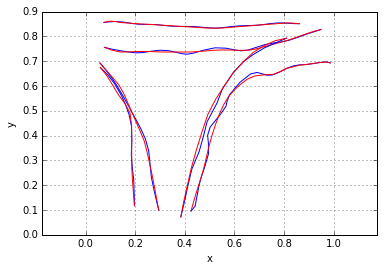

In [184]:
n_curves = len(curves)
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
plt.grid()
axis_size = plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(handles = [line_opt,line_observed] )
print "L^2 error = %f" % np.sqrt( np.dot(x_opt - x_observed,x_opt-x_observed)+np.dot(y_opt-y_observed, y_opt-y_observed) )

We can also visualize the the potential funciton on a regular grid

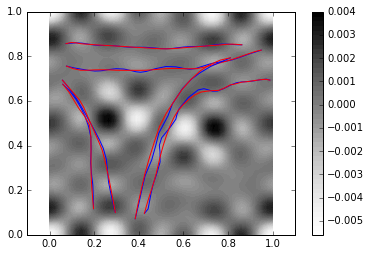

In [185]:
x_grid,y_grid = np.meshgrid( np.linspace(0,1,50) , np.linspace(0,1,50))
V = np.zeros_like(x_grid)
for kx in range(-k_max,k_max+1):
    for ky in range(-k_max,k_max+1):
        V += theta_opt[kx,ky] * np.exp(2*np.pi*1j*(kx*x_grid + ky*y_grid)).real
plt.contourf(x_grid,y_grid,V,50,cmap='Greys')
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
axis_size= plt.axis('equal')